# Alice's Workspace for Final Project

In [354]:
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
!pwd

/media/notebooks/w261_final_project/misc_code


In [3]:
# global vars (paths) - ADJUST AS NEEDED
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.15.0.jar"
HDFS_DIR = "/user/root/final_project"
#!pwd
HOME_DIR = "/media/notebooks/w261_final_project/misc_code" 

In [4]:
# save path for use in Hadoop jobs (-cmdenv PATH={PATH})
from os import environ
PATH  = environ['PATH']

In [5]:
# data path
ENRON = "data/train_005.txt"

#### Setup Spark Session

In [6]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "FinalProject_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

#### Load data

In [19]:
# create dataframe from train_0005.tsv
df = spark.read.csv('../data/train_005.tsv', sep='\t')
traindf = spark.read.csv('../data/temp_wei.txt', sep='\t')

In [12]:
SEED = 2615

def splitIntoTestAndTrain(df):
    '''randomly splits 80/20 into training and testing dataframes'''
    splits = df.randomSplit([0.2, 0.8], seed=SEED)
    testDf = splits[0]
    trainDf = splits[1]
    return testDf, trainDf
testdf, traindf = splitIntoTestAndTrain(df)

## EDA

#### 1. Take a first look at the data

In [142]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

##### All of them are in string. We know some columns are numerical variables. We need to fix that later

In [20]:
traindf.head(3)

[Row(_c0='0', _c1='0', _c2='1', _c3='10', _c4='2', _c5='4851', _c6='139', _c7='7', _c8='2', _c9='53', _c10='0', _c11='1', _c12=None, _c13='2', _c14='05db9164', _c15='403ea497', _c16='2cbec47f', _c17='3e2bfbda', _c18='25c83c98', _c19=None, _c20='866e2a5e', _c21='5b392875', _c22='a73ee510', _c23='3b08e48b', _c24='a15790a3', _c25='21a23bfe', _c26='a0abbb5b', _c27='07d13a8f', _c28='e3209fc2', _c29='587267a3', _c30='d4bb7bd8', _c31='a78bd508', _c32='21ddcdc9', _c33='5840adea', _c34='c2a93b37', _c35=None, _c36='3a171ecb', _c37='1793a828', _c38='e8b83407', _c39='2fede552'),
 Row(_c0='0', _c1='0', _c2='93', _c3='21', _c4='21', _c5='2387', _c6='73', _c7='7', _c8='24', _c9='174', _c10='0', _c11='6', _c12=None, _c13='21', _c14='05db9164', _c15='421b43cd', _c16='e8c51b7b', _c17='29998ed1', _c18='25c83c98', _c19='fe6b92e5', _c20='dc7659bd', _c21='0b153874', _c22='a73ee510', _c23='fed0f64c', _c24='e51ddf94', _c25='6aaba33c', _c26='3516f6e6', _c27='b28479f6', _c28='e1ac77f7', _c29='b041b04a', _c30='e

##### There is no column names and the values are all converted to bitwise info.

In [216]:
traindf.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------+--------+--------+--------+--------------------+--------+--------+--------------------+--------+--------+--------+--------+--------+--------------------+--------+--------+---------+--------+--------+--------+--------+--------+-----------+--------+---------+--------+
|summary|                _c0|               _c1|               _c2|               _c3|              _c4|              _c5|               _c6|              _c7|               _c8|               _c9|              _c10|             _c11|              _c12|              _c13|    _c14|    _c15|    _c16|    _c17|                _c18|    _c19|    _c20|                _c21|    _c22|    _c23|    _c24|    _c25|    _c26|                _c27|    _c28|    _c29|

__Based on the description from the competition and also the description above, we know that column 0-13 are integer values, column 14-39 are categorical values. There is no column that has zero valid data.__

In [21]:
from pyspark.sql.types import *
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 

In [22]:
numerical_col = ['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13']

In [23]:
df = convertColumn(df, numerical_col, FloatType())

In [26]:
df.printSchema()

root
 |-- _c0: float (nullable = true)
 |-- _c1: float (nullable = true)
 |-- _c2: float (nullable = true)
 |-- _c3: float (nullable = true)
 |-- _c4: float (nullable = true)
 |-- _c5: float (nullable = true)
 |-- _c6: float (nullable = true)
 |-- _c7: float (nullable = true)
 |-- _c8: float (nullable = true)
 |-- _c9: float (nullable = true)
 |-- _c10: float (nullable = true)
 |-- _c11: float (nullable = true)
 |-- _c12: float (nullable = true)
 |-- _c13: float (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = true)
 |-- _c28: 

### 2. Df is corrected ->  train/test split

In [151]:
splits = df.randomSplit([0.2, 0.8], seed=2615)
testdf = splits[0]
traindf = splits[1]

#### Label distribution

In [24]:
testdf.groupBy("_c0").count().show()

+---+-----+
|_c0|count|
+---+-----+
|  0| 3371|
|  1| 1213|
+---+-----+



In [25]:
traindf.groupBy("_c0").count().show()

+---+-----+
|_c0|count|
+---+-----+
|1.0| 5900|
|0.0|17057|
+---+-----+



#### There's about 25% of label 1 and 75% of label 0 in both train/test set. We do not have a balanced dataset. However, the imbalance is also not as extreme as say fraud detection that may be just under 10% of the samples.

In [ ]:
traindf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traindf.columns]).show()

In [382]:
#from pyspark.sql.functions import col, countDistinct
x = traindf.agg(*(countDistinct(col(c)).alias(c) for c in traindf.columns)).show()

+---+---+----+---+---+----+---+---+---+---+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|_c0|_c1| _c2|_c3|_c4| _c5|_c6|_c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15| _c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34|_c35|_c36|_c37|_c38|_c39|
+---+---+----+---+---+----+---+---+---+---+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|  2| 92|1189|325| 69|8400|942|365| 61|972|   8|  68|  43| 106| 236| 435|10328|7028|  78|   9|4533| 131|   3|4812|2676|9670|2172|  25|2850|8588|   9|1564| 697|   3|9201|   9|  14|4099|  44|3140|
+---+---+----+---+---+----+---+---+---+---+----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



""


In [27]:
columns = traindf.columns[1:]
distinct_count = []
for col in columns:
    distinct_count.append(traindf.select(col).distinct().count())

In [28]:
for col, count in zip(columns, distinct_count):
    print (col, ":", count)

_c1 : 96
_c2 : 1349
_c3 : 359
_c4 : 71
_c5 : 9770
_c6 : 1031
_c7 : 393
_c8 : 64
_c9 : 1043
_c10 : 9
_c11 : 71
_c12 : 48
_c13 : 110
_c14 : 261
_c15 : 450
_c16 : 12575
_c17 : 8308
_c18 : 86
_c19 : 10
_c20 : 4987
_c21 : 142
_c22 : 3
_c23 : 5481
_c24 : 2874
_c25 : 11740
_c26 : 2306
_c27 : 25
_c28 : 3117
_c29 : 10367
_c30 : 9
_c31 : 1684
_c32 : 771
_c33 : 4
_c34 : 11157
_c35 : 10
_c36 : 14
_c37 : 4733
_c38 : 45
_c39 : 3622


In [220]:
traindf.select(numerical_col[0:7]).describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|summary|                _c0|               _c1|               _c2|               _c3|              _c4|              _c5|               _c6|
+-------+-------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+
|  count|              18379|             10109|             18379|             14386|            14314|            17905|             14191|
|   mean|0.25991620871646987|3.5502027895934316|101.80967408455302| 25.63763381064924| 7.30068464440408|18436.65942474169|111.70875907265167|
| stddev|0.43860031921230597| 9.293289659497264|374.02991892400274|331.46919953261744|8.624079890068804|68931.50353591116|332.34996893862655|
|    min|                0.0|               0.0|              -2.0|               0.0|              0.0|              0.0|               0.0|
|    m

In [221]:
traindf.select(numerical_col[7:]).describe().show()

+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|              _c7|               _c8|               _c9|              _c10|             _c11|              _c12|              _c13|
+-------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|            17600|             18369|             17600|             10109|            17600|              4282|             14314|
|   mean|17.12034090909091|12.419293374707387|106.89028409090909|0.6220199821940845|2.790738636363636|0.8895375992526856| 8.168366634064553|
| stddev|66.91093732423182|14.088934412061754|227.30410625706682|0.6948805353765156|5.310155836571858|3.8061148775636693|11.428526114043635|
|    min|              0.0|               0.0|               0.0|               0.0|              0.0|               0.0|               0.0|
|    max|    

In [29]:
from pyspark.sql.functions import rand

#### Check NA

In [286]:
from pyspark.sql.functions import isnan, when, count, col, desc
traindf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traindf.columns]).show()

+---+----+---+----+----+---+----+---+---+---+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+
|_c0| _c1|_c2| _c3| _c4|_c5| _c6|_c7|_c8|_c9|_c10|_c11| _c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31|_c32|_c33|_c34| _c35|_c36|_c37|_c38|_c39|
+---+----+---+----+----+---+----+---+---+---+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+
|  0|8270|  0|3993|4065|474|4188|779| 10|779|8270| 779|14097|4065|   0|   0| 653| 653|   0|2260|   0|   0|   0|   0|   0| 653|   0|   0|   0| 653|   0|   0|8082|8082| 653|13890|   0| 653|8082|8082|
+---+----+---+----+----+---+----+---+---+---+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+-----+----+----+----+----+



In [353]:
traindf.dropna().describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+--------+--------+--------+--------------------+--------+--------+--------------------+--------+--------+--------+--------+--------------------+---------+--------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|summary|               _c0|               _c1|               _c2|               _c3|               _c4|               _c5|               _c6|              _c7|               _c8|               _c9|              _c10|              _c11|              _c12|              _c13|               _c14|    _c15|    _c16|    _c17|                _c18|    _c19|    _c20|                _c21|    _c22|    _c23|    _c24|    _c25|                _c26|    

In [35]:
import pyspark.sql.functions

#### Reaplace null with median or most frequent variables

##### Just for seeing the values below

In [31]:
[x[0] for x in traindf.approxQuantile(traindf.columns[1:14], [0.5], 0)]

[1.0, 3.0, 6.0, 4.0, 2812.0, 33.0, 3.0, 7.0, 37.0, 1.0, 1.0, 0.0, 4.0]

In [397]:
# traindf.groupBy(traindf.columns[14:]).count().sort(desc("count")).collect()[0]
traindf.groupBy(traindf.columns[14:]).count().sort(desc("count")).collect()[0]

Row(_c14='05db9164', _c15='95e2d337', _c16='95c48c52', _c17='30b862e7', _c18='25c83c98', _c19='7e0ccccf', _c20='a6950954', _c21='37e4aa92', _c22='a73ee510', _c23='3b08e48b', _c24='a2407991', _c25='f0d5cc59', _c26='decd9980', _c27='1adce6ef', _c28='559cd202', _c29='e9194f3c', _c30='e5ba7672', _c31='7b06fafe', _c32='85684dc0', _c33='a458ea53', _c34='cb105f80', _c35='ad3062eb', _c36='be7c41b4', _c37='16bb3de8', _c38='2bf691b1', _c39='d3b2f8c3', count=1)

##### The actual code

In [39]:
fillna_dict_num = {key: value for (key, value) in zip(traindf.columns[1:14], [x[0] for x in traindf.approxQuantile(traindf.columns[1:14],[0.5],0.05)])}
# fillna_dict_cat = {key: value for (key, value) in zip(traindf.columns[14:], traindf.groupBy(traindf.columns[14:]).count().sort(desc("count")).collect()[0])}
fillna_dict_cat = {key: value for (key, value) in zip(traindf.columns[14:], traindf.groupBy(traindf.columns[14:]).count().sort(desc("count")).collect()[0])}
traindf_nafilled = traindf.na.fill(fillna_dict_num).na.fill(fillna_dict_cat)
#traindf_nafilled = traindf.na.fill(fillna_dict_cat)  

In [40]:
col_names = traindf.columns

In [251]:
corr_matrix = np.zeros((14, 14), dtype=float)
for i in range(14):
    for j in range(i,14):
        corr_matrix[i,j] = round(traindf.stat.corr(col_names[i], col_names[j]),4)

In [391]:
df = traindf_nafilled.select(traindf.columns[1:14])
col_names = df.columns
features = df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

In [392]:
corr_df

,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9,_c10,_c11,_c12,_c13
_c1,1.000000,0.008651,0.033606,0.065257,-0.054907,-0.071583,0.451491,0.104399,0.080020,0.338796,0.301159,0.087489,-0.008953
_c2,0.008651,1.000000,-0.008189,-0.089137,-0.001823,-0.012534,0.010269,-0.036412,-0.006191,-0.007540,0.016945,-0.009743,-0.051815
_c3,0.033606,-0.008189,1.000000,0.032565,0.005937,-0.001337,-0.002074,0.034953,-0.003817,-0.014946,-0.007545,-0.003713,0.032237
_c4,0.065257,-0.089137,0.032565,1.000000,-0.084307,0.017896,0.038591,0.500811,0.171580,0.036767,0.051279,0.022434,0.711370
_c5,-0.054907,-0.001823,0.005937,-0.084307,1.000000,0.014377,-0.057033,-0.129144,-0.064926,0.062959,-0.109539,-0.027344,-0.063416
_c6,-0.071583,-0.012534,-0.001337,0.017896,0.014377,1.000000,-0.036820,0.037605,0.217780,-0.133154,-0.053815,-0.023411,0.078911
_c7,0.451491,0.010269,-0.002074,0.038591,-0.057033,-0.036820,1.000000,0.097382,0.264266,0.132212,0.698788,0.099413,-0.005526
_c8,0.104399,-0.036412,0.034953,0.500811,-0.129144,0.037605,0.097382,1.000000,0.232071,-0.025288,0.158783,0.040116,0.455559
_c9,0.080020,-0.006191,-0.003817,0.171580,-0.064926,0.217780,0.264266,0.232071,1.000000,-0.084883,0.411705,0.049519,0.231035
_c10,0.338796,-0.007540,-0.014946,0.036767,0.062959,-0.133154,0.132212,-0.025288,-0.084883,1.000000,0.156744,0.057654,-0.059781


In [254]:
pd.DataFrame(corr_matrix).replace(0, '-')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0.1067,0.0436,0.0127,-0.0513,-0.0835,-0.0643,0.0847,-0.0303,0.0232,0.2038,0.166,0.0646,-0.1000
1,-,1,0.0101,0.0342,0.0851,-0.0712,-0.0658,0.4559,0.1207,0.0925,0.4881,0.3178,0.0913,0.0093
2,-,-,1,-0.0088,-0.0831,-0.0018,-0.0115,0.0103,-0.0363,-0.006,0.0121,0.017,-0.0097,-0.0490
3,-,-,-,1,0.0356,0.0058,-0.0012,-0.002,0.0365,-0.0036,-0.0014,-0.0074,-0.0038,0.0348
4,-,-,-,-,1,-0.0974,0.0248,0.0455,0.5285,0.1839,0.1613,0.0646,0.0263,0.7365
5,-,-,-,-,-,1,0.0003,-0.0585,-0.1286,-0.0708,-0.148,-0.1161,-0.0272,-0.0748
6,-,-,-,-,-,-,1,-0.03,0.0433,0.2256,-0.1362,-0.039,-0.0207,0.0809
7,-,-,-,-,-,-,-,1,0.0983,0.2658,0.2505,0.6988,0.0996,0.0016
8,-,-,-,-,-,-,-,-,1,0.2347,0.1876,0.162,0.0401,0.4810
9,-,-,-,-,-,-,-,-,-,1,0.0681,0.4152,0.0501,0.2386


In [255]:
cov_matrix = np.zeros((14, 14), dtype=float)
for i in range(14):
    for j in range(i,14):
        cov_matrix[i,j] = round(traindf.stat.cov(col_names[i], col_names[j]),4)

In [256]:
pd.DataFrame(cov_matrix).replace(0, '-')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.1924,0.3328,7.157,1.6319,-0.1844,-2494.26,-8.3381,2.4361,-0.1873,2.2734,0.0537,0.3806,0.0531,-0.4666
1,-,50.621,26.9408,71.4781,4.9616,-34491.8,-138.476,212.691,12.0956,147.042,2.0876,11.8188,1.2178,0.7013
2,-,-,139898,-968.32,-254.553,-46504.4,-1273.05,252.659,-191.442,-504.743,2.7189,33.3214,-6.8329,-195.0512
3,-,-,-,86111.7,85.4624,115415,-101.112,-38.3613,150.781,-233.879,-0.2512,-11.3808,-2.081,108.6733
4,-,-,-,-,67.1057,-54357.1,60.0177,24.4437,60.9911,336.66,0.7943,2.768,0.4042,64.1957
5,-,-,-,-,-,4.63754e+09,5187.21,-261340,-123373,-1.07785e+06,-6058.63,-41331.2,-3475.9,-54168.8509
6,-,-,-,-,-,-,87481.3,-581.962,180.22,14913.3,-24.2066,-60.3011,-11.4754,254.4661
7,-,-,-,-,-,-,-,4299.2,90.7597,3894.45,9.8728,239.471,12.2429,1.1370
8,-,-,-,-,-,-,-,-,198.474,738.795,1.5887,11.9262,1.0603,72.1063
9,-,-,-,-,-,-,-,-,-,49940.9,9.1523,485.001,21.0137,567.3472


In [174]:
! pip install pyspark_dist_explore

distributed 1.22.0 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


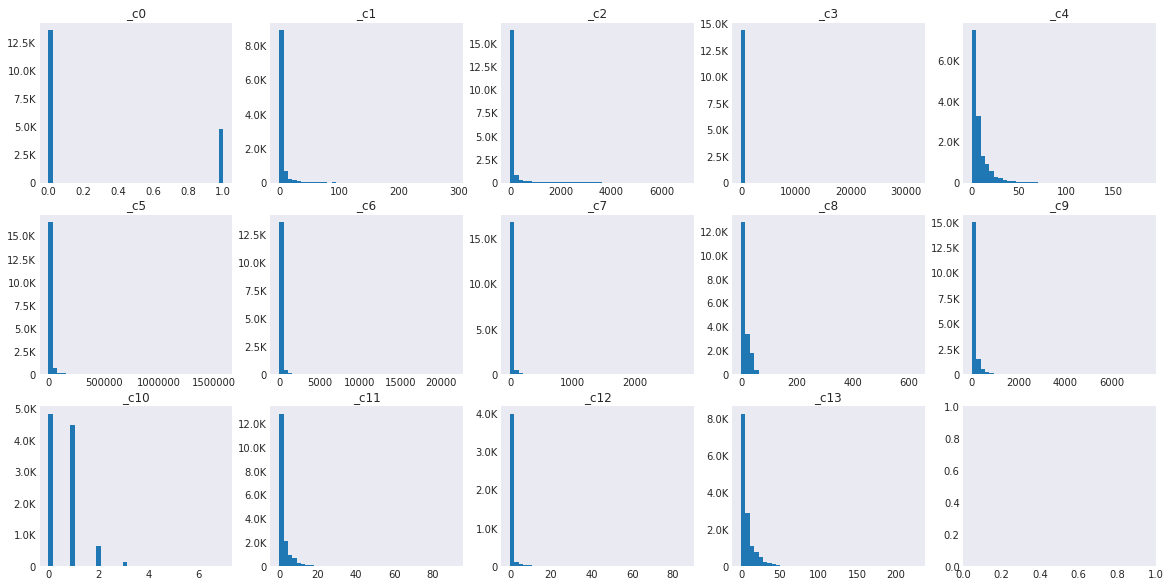

In [278]:
from pyspark_dist_explore import hist, distplot
fig, axes = plt.subplots(nrows = 3, ncols=5)
fig.set_size_inches(20,10)
for i, col in enumerate(numerical_col):
    hist(axes[i//5, i%5], traindf_num.select(col), bins = 40)
    axes[i//5, i%5].set_title(col)

In [122]:
from pyspark.mllib.stat import Statistics

#### Check top occuring values per Columns

In [ ]:
traindf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

In [531]:
[x[0] for x in traindf.groupBy(c).count().sort(desc("count")).select(c).collect() for c in traindf.columns[14:16]]

[[Row(_c14='05db9164'),
  Row(_c14='68fd1e64'),
  Row(_c14='5a9ed9b0'),
  Row(_c14='8cf07265'),
  Row(_c14='be589b51'),
  Row(_c14='5bfa8ab5'),
  Row(_c14='87552397'),
  Row(_c14='f473b8dc'),
  Row(_c14='39af2607'),
  Row(_c14='ae82ea21'),
  Row(_c14='9a89b36c'),
  Row(_c14='17f69355'),
  Row(_c14='09ca0b81'),
  Row(_c14='241546e0'),
  Row(_c14='75ac2fe6'),
  Row(_c14='41edac3d'),
  Row(_c14='439a44a4'),
  Row(_c14='b455c6d7'),
  Row(_c14='7e5c2ff4'),
  Row(_c14='1464facd'),
  Row(_c14='fbc55dae'),
  Row(_c14='d4b08d58'),
  Row(_c14='287e684f'),
  Row(_c14='3c9d8785'),
  Row(_c14='da4eff0f'),
  Row(_c14='2d4ea12b'),
  Row(_c14='291b7ba2'),
  Row(_c14='c71ae391'),
  Row(_c14='28e55712'),
  Row(_c14='65aada8c'),
  Row(_c14='24eda356'),
  Row(_c14='6062d843'),
  Row(_c14='98237733'),
  Row(_c14='e8ef605b'),
  Row(_c14='3b65d647'),
  Row(_c14='46300ee3'),
  Row(_c14='64e77ae7'),
  Row(_c14='fb174e6b'),
  Row(_c14='561bf9d4'),
  Row(_c14='88abfaf6'),
  Row(_c14='49807078'),
  Row(_c14='4670

In [535]:
[x[0] for x in traindf.groupBy('_c14').count().sort(desc("count")).select('_c14').head(10)]

['05db9164',
 '68fd1e64',
 '5a9ed9b0',
 '8cf07265',
 'be589b51',
 '5bfa8ab5',
 '87552397',
 'f473b8dc',
 '39af2607',
 'ae82ea21']

In [549]:
{key: value for (key, value) in zip(traindf.columns[14:16], [[x[1] for x in traindf.groupBy(c).count().sort(desc("count")).head(10)] for c in traindf.columns[14:16]])}

{'_c14': [9262, 3033, 1575, 897, 610, 435, 356, 250, 200, 188],
 '_c15': [2175, 756, 712, 681, 657, 624, 559, 495, 430, 397]}

In [551]:
topCounts_dict = {key: value for (key, value) in zip(traindf.columns, [[x[1] for x in traindf.groupBy(c).count().sort(desc("count")).head(2)] for c in traindf.columns])}

In [563]:
print([(key, topCounts_dict[key]) for key in topCounts_dict])

[('_c0', [13602, 4777], '\n'), ('_c1', [8270, 4288], '\n'), ('_c2', [3175, 2832], '\n'), ('_c3', [3993, 2342], '\n'), ('_c4', [4065, 2298], '\n'), ('_c5', [474, 430], '\n'), ('_c6', [4188, 965], '\n'), ('_c7', [4016, 2363], '\n'), ('_c8', [2165, 1412], '\n'), ('_c9', [779, 657], '\n'), ('_c10', [8270, 4824], '\n'), ('_c11', [6062, 4165], '\n'), ('_c12', [14097, 3216], '\n'), ('_c13', [4065, 2267], '\n'), ('_c14', [9262, 3033], '\n'), ('_c15', [2175, 756], '\n'), ('_c16', [653, 424], '\n'), ('_c17', [653, 621], '\n'), ('_c18', [12304, 2934], '\n'), ('_c19', [7250, 4029], '\n'), ('_c20', [403, 236], '\n'), ('_c21', [10909, 3071], '\n'), ('_c22', [16559, 1815], '\n'), ('_c23', [4134, 270], '\n'), ('_c24', [609, 390], '\n'), ('_c25', [653, 430], '\n'), ('_c26', [609, 447], '\n'), ('_c27', [6392, 6373], '\n'), ('_c28', [292, 188], '\n'), ('_c29', [653, 430], '\n'), ('_c30', [8386, 2448], '\n'), ('_c31', [598, 532], '\n'), ('_c32', [8082, 6355], '\n'), ('_c33', [8082, 3496], '\n'), ('_c34', 

In [564]:
print(pd.DataFrame(topCounts_dict))

     _c0   _c1   _c2   _c3   _c4  _c5   _c6   _c7   _c8  _c9  ...   _c30  \
0  13602  8270  3175  3993  4065  474  4188  4016  2165  779  ...   8386   
1   4777  4288  2832  2342  2298  430   965  2363  1412  657  ...   2448   

   _c31  _c32  _c33  _c34   _c35  _c36  _c37  _c38  _c39  
0   598  8082  8082   653  13890  8102   923  8082  8082  
1   532  6355  3496   430   2596  3607   858  2554   744  

[2 rows x 40 columns]


In [ ]:
{traindf.columns[14:16]:}

In [424]:
for col in traindf.columns[14:16]:
    traindf.groupBy(col).count().sort(desc("count")).show()

+--------+-----+
|    _c14|count|
+--------+-----+
|05db9164| 9262|
|68fd1e64| 3033|
|5a9ed9b0| 1575|
|8cf07265|  897|
|be589b51|  610|
|5bfa8ab5|  435|
|87552397|  356|
|f473b8dc|  250|
|39af2607|  200|
|ae82ea21|  188|
|9a89b36c|  139|
|17f69355|  109|
|09ca0b81|   94|
|241546e0|   87|
|75ac2fe6|   64|
|41edac3d|   57|
|439a44a4|   54|
|b455c6d7|   44|
|7e5c2ff4|   42|
|1464facd|   39|
+--------+-----+
only showing top 20 rows

+--------+-----+
|    _c15|count|
+--------+-----+
|38a947a1| 2175|
|207b2d81|  756|
|38d50e09|  712|
|1cfdf714|  681|
|287130e0|  657|
|09e68b86|  624|
|4f25e98b|  559|
|421b43cd|  495|
|58e67aaf|  430|
|80e26c9b|  397|
|89ddfee8|  376|
|95e2d337|  346|
|08d6d899|  329|
|2c16a946|  313|
|04e09220|  290|
|f0cf0024|  278|
|0468d672|  221|
|a796837e|  215|
|6887a43c|  188|
|e112a9de|  175|
+--------+-----+
only showing top 20 rows



In [84]:
from pyspark.sql.functions import countDistinct,col
df_counts = df_0005.agg(*(countDistinct(col(c)).alias(c) for c in df_0005.columns)).show()
df_counts.show()

+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+
|Label| I0|  I1| I2| I3|  I4|  I5| I6| I7|  I8| I9|I10|I11|I12| C0| C1|   C2|  C3| C4| C5|  C6| C7| C8|  C9| C10|  C11| C12|C13| C14|  C15|C16| C17|C18|C19|  C20|C21|C22| C23|C24| C25|
+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+
|    2| 95|1349|358| 70|9769|1030|392| 63|1042|  8| 70| 47|109|261|450|12574|8307| 86|  9|4987|142|  3|5481|2874|11739|2306| 25|3117|10366|  9|1684|770|  3|11156|  9| 14|4732| 44|3621|
+-----+---+----+---+---+----+----+---+---+----+---+---+---+---+---+---+-----+----+---+---+----+---+---+----+----+-----+----+---+----+-----+---+----+---+---+-----+---+---+----+---+----+



In [192]:
#Replace low frequentcy values with -1
from pyspark.sql.functions import when
#update numerical values
threshold_num = [x[0] for x in traindf_nafilled.approxQuantile(traindf_nafilled.columns[1:14],[0.5],0)]
targetDF = traindf_nafilled
for i in range(13):
    k = threshold_num[i]
    colname = traindf_nafilled.schema.names[i+1]
    targetDF = targetDF.withColumn(colname, when(targetDF[colname] <= k, -1).otherwise(targetDF[colname]))
    
targetDF.show()

+---+----+-----+----+----+-------+-----+-----+----+-----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|_c0| _c1|  _c2| _c3| _c4|    _c5|  _c6|  _c7| _c8|  _c9|_c10|_c11|_c12|_c13|    _c14|    _c15|    _c16|    _c17|    _c18|    _c19|    _c20|    _c21|    _c22|    _c23|    _c24|    _c25|    _c26|    _c27|    _c28|    _c29|    _c30|    _c31|    _c32|    _c33|    _c34|    _c35|    _c36|    _c37|    _c38|    _c39|
+---+----+-----+----+----+-------+-----+-----+----+-----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|0.0|-1.0| -1.0|10.0|-1.0| 4851.0|139.0|  7.0|-1.0| 53.0|-1.0|-1

In [210]:
# import findspark
# findspark.init()
import pyspark as ps
from pyspark.sql import SQLContext, Column
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, count as sparkcount, when, lit
from pyspark.sql.types import StringType
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml import Pipeline
import json 

df = traindf_nafilled

from pyspark.sql.functions import col

def withMeta(self, alias, meta):
    sc = ps.SparkContext._active_spark_context
    jmeta = sc._gateway.jvm.org.apache.spark.sql.types.Metadata
    return Column(getattr(self._jc, "as")(alias, jmeta.fromJson(json.dumps(meta))))

def group_low_freq(df,inColumns,threshold=.01,group_text='other'):
    """
    Index string columns and group all observations that occur in less then a threshold% of the rows in df per column.
    :param df: A pyspark.sql.dataframe.DataFrame
    :param inColumns: String columns that need to be indexed
    :param group_text: String to use as replacement for the observations that need to be grouped.
    """
    total = df.count()
    for string_col in inColumns:
        # Apply string indexer
        pipeline = Pipeline(stages=[StringIndexer(inputCol=string_col, outputCol="ix_"+string_col)])
        df = pipeline.fit(df).transform(df)

        # Calculate the number of unique elements to keep
        n_to_keep = df.groupby(string_col).agg((sparkcount(string_col)/total).alias('perc')).filter(col('perc')>threshold).count()

        # If elements occur below (threshold * number of rows), replace them with n_to_keep.
        this_meta = df.select('ix_' + string_col).schema.fields[0].metadata
        if n_to_keep != len(this_meta['ml_attr']['vals']):  
            this_meta['ml_attr']['vals'] = this_meta['ml_attr']['vals'][0:(n_to_keep+1)]
            this_meta['ml_attr']['vals'][n_to_keep] = group_text    
            df = df.withColumn('ix_'+string_col,when(col('ix_'+string_col)>=n_to_keep,lit(n_to_keep)).otherwise(col('ix_'+string_col)))

        # add the new column with correct metadata, remove original.
        df = df.withColumn('ix_'+string_col, withMeta(col('ix_'+string_col), "", this_meta))

    return df



df = group_low_freq(df,df.columns,0.25)    

ix_cols = [x for x in df.columns if 'ix_' in x]
for string_col in ix_cols:    
    idx_to_string = IndexToString(inputCol=string_col, outputCol=string_col[3:]+'grouped')
    df = idx_to_string.transform(df)

df.show()

+---+----+-----+----+----+-------+-----+-----+----+-----+----+----+----+----+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------+------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----

In [196]:
# import statistics
newdf = traindf_nafilled.select('_c14')
# # traindf.approxQuantile(traindf.columns[1:14],[0.5],0)
# threshold = traindf_nafilled[1:13].approxQuantile(traindf_nafilled[1:13].columns, [0.5], 0)
# threshold
threshold_num = [x[0] for x in traindf.approxQuantile(traindf.columns[1:14],[0.5],0)]
freqDF = newdf.groupBy(newdf.columns).count()
threshold = freqDF.approxQuantile(freqDF.columns, [0.5], 0)
threshold

IllegalArgumentException: 'requirement failed: Quantile calculation for column _c14 with data type StringType is not supported.'

In [1]:
dictA = {'Name': 'Zabra', 'Age': 7}

In [4]:
print ([dictA.get(x) for x in dictA])

['Zabra', 7]


In [5]:
print ([x for x in dictA])

['Name', 'Age']


In [7]:
"hello".paste("x")

AttributeError: 'str' object has no attribute 'paste'